In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
sns.set_style('whitegrid')



### Data preparation


In [2]:
# Read the data
df = pd.read_csv('../data/processed_data_news_stock.csv')
df.dropna(inplace=True)



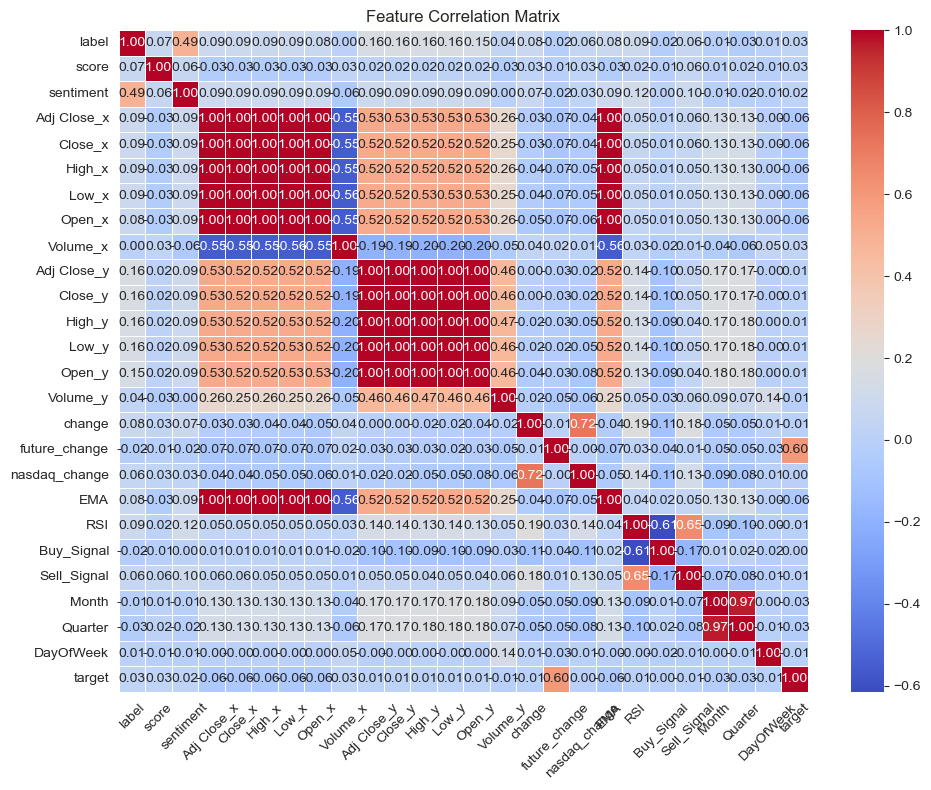

DataFrame Columns: ['summary', 'company_x', 'label', 'score', 'sentiment', 'Date', 'Adj Close_x', 'Close_x', 'High_x', 'Low_x', 'Open_x', 'Volume_x', 'Adj Close_y', 'Close_y', 'High_y', 'Low_y', 'Open_y', 'Volume_y', 'company_y', 'change', 'future_change', 'nasdaq_change', 'EMA', 'RSI', 'Buy_Signal', 'Sell_Signal', 'Month', 'Quarter', 'DayOfWeek', 'target']


In [3]:

# 计算相关矩阵
num_features = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[num_features].corr()

# make a heatmap of the correlation matrix to avoid multicollinearity
plt.figure(figsize=(10, 8))  # 设置图表大小
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')  # 添加标题
plt.xticks(rotation=45)  # 旋转x轴标签
plt.yticks(rotation=0)  # 旋转y轴标签
plt.tight_layout()  # 自动调整布局
plt.show()

# 打印数据框的列名
print("DataFrame Columns:", df.columns.tolist())



In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
# Split the data into training and test sets based on the Date column
features = [ 'score','sentiment','target','Volume_x','change','Volume_y','EMA','Buy_Signal','Sell_Signal','Month','Quarter','DayOfWeek'] 
df = df[features]
training_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
X_train = training_data.drop('target', axis=1)
y_train = training_data['target']
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']



## Model building

In [5]:
from sklearn.pipeline import Pipeline
transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['score', 'sentiment', 'Volume_x', 'change', 'Volume_y', 'EMA', 'Buy_Signal', 'Sell_Signal','Month','Quarter','DayOfWeek'])
    ])


In [6]:
# xgboost
from xgboost import XGBClassifier
pipeline = Pipeline([('transformer', transformer), ('model', XGBClassifier(random_state=42))])
grid_param = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    }
grid_search = GridSearchCV(pipeline, grid_param, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Best parameters found:  {'model__colsample_bytree': 1.0, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best accuracy found:  0.6249276425747013


In [7]:
# evaluate the model
y_pred_xgboost = grid_search.predict(X_test)
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
print("Accuracy: ", accuracy_xgboost)


Accuracy:  0.6209677419354839


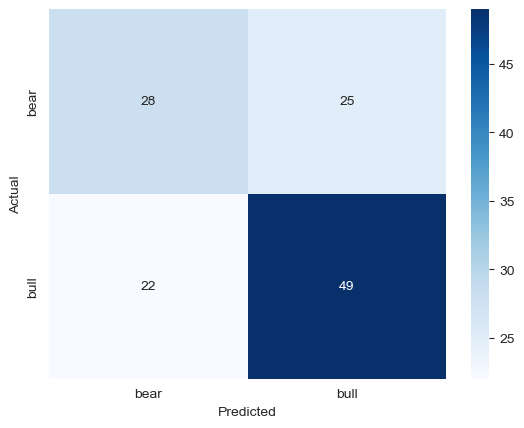

In [8]:
# plot the confusion matrix 0 is bear, 1 is bull
from sklearn.metrics import confusion_matrix
conf_matrix_xgboost = confusion_matrix(y_test, y_pred_xgboost)
sns.heatmap(conf_matrix_xgboost, annot=True, fmt='d', cmap='Blues', xticklabels=['bear', 'bull'], yticklabels=['bear', 'bull'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
# save the model
import joblib
joblib.dump(grid_search, f'../models/xgboost_model_{accuracy_xgboost}.pkl')

['../models/xgboost_model_0.6209677419354839.pkl']

## Model without news

In [10]:
features_without_news = ['target','Volume_x','change','Volume_y','EMA','Buy_Signal','Sell_Signal','Month','Quarter','DayOfWeek'] 
df_without_news = df[features_without_news]
training_data_without_news, test_data_without_news = train_test_split(df_without_news, test_size=0.1, random_state=42)
X_train_without_news = training_data_without_news.drop('target', axis=1)
y_train_without_news = training_data_without_news['target']
X_test_without_news = test_data_without_news.drop('target', axis=1)
y_test_without_news = test_data_without_news['target']


In [11]:
transformer_without_news = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Volume_x', 'change', 'Volume_y', 'EMA', 'Buy_Signal', 'Sell_Signal','Month','Quarter','DayOfWeek'])
    ])

In [12]:
pipeline_without_news = Pipeline([('transformer', transformer_without_news), ('model', XGBClassifier(random_state=42))])
grid_param_without_news = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    }
grid_search_without_news = GridSearchCV(pipeline_without_news, grid_param_without_news, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_without_news.fit(X_train_without_news, y_train_without_news)
print("Best parameters found: ", grid_search_without_news.best_params_)
print("Best accuracy found: ", grid_search_without_news.best_score_)

Best parameters found:  {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300, 'model__subsample': 1.0}
Best accuracy found:  0.6474420121478944


In [15]:
y_pred_xgboost_without_news = grid_search_without_news.predict(X_test_without_news)
accuracy_xgboost_without_news = accuracy_score(y_test_without_news, y_pred_xgboost_without_news)
print("Accuracy: ", accuracy_xgboost_without_news)


Accuracy:  0.6612903225806451


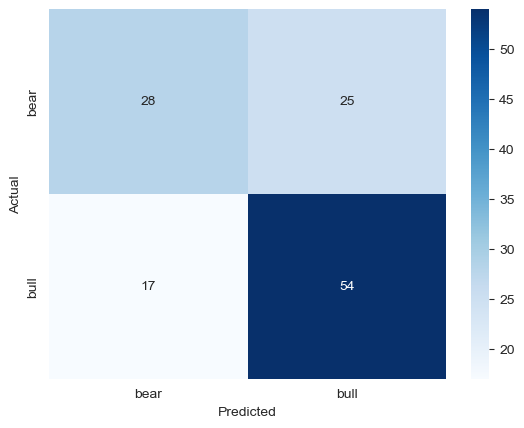

In [14]:
conf_matrix_xgboost_without_news = confusion_matrix(y_test_without_news, y_pred_xgboost_without_news)
sns.heatmap(conf_matrix_xgboost_without_news, annot=True, fmt='d', cmap='Blues', xticklabels=['bear', 'bull'], yticklabels=['bear', 'bull'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# test the result between model with news and model without news
import statsmodels.api as sm

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming model_a and model_b are your two models
# and test_dataset is your test data

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    true_labels = y_test

    

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, precision, recall, f1, conf_matrix

# Evaluate both models
accuracy_with_news, precision_with_news, recall_with_news, f1_with_news, conf_matrix_with_news = evaluate_model(grid_search, X_test, y_test)
accuracy_without_news, precision_without_news, recall_without_news, f1_without_news, conf_matrix_without_news = evaluate_model(grid_search_without_news, X_test_without_news, y_test_without_news)

# Print results
print("Model with news - Accuracy:", accuracy_with_news, "Precision:", precision_with_news, "Recall:", recall_with_news, "F1:", f1_with_news)
print("Confusion Matrix A:\n", conf_matrix_with_news)

print("Model without news - Accuracy:", accuracy_without_news, "Precision:", precision_without_news, "Recall:", recall_without_news, "F1:", f1_without_news)
print("Confusion Matrix B:\n", conf_matrix_without_news)

Model with news - Accuracy: 0.6209677419354839 Precision: 0.6184960767218832 Recall: 0.6209677419354839 F1: 0.6193688780414053
Confusion Matrix A:
 [[28 25]
 [22 49]]
Model without news - Accuracy: 0.6612903225806451 Precision: 0.65733405925321 Recall: 0.6612903225806451 F1: 0.6564976958525345
Confusion Matrix B:
 [[28 25]
 [17 54]]


In [31]:
from scipy import stats

# Assuming predictions_a and predictions_b are the predictions from model A and B respectively
# and they are binary or categorical

# Perform a paired t-test on the accuracy scores
t_stat, p_value = stats.ttest_rel(y_pred_xgboost, y_pred_xgboost_without_news)

# Significance level
alpha = 0.05

# Decision
if p_value <= alpha:
    print("There is a statistically significant difference between the models.")
else:
    print("There is no statistically significant difference between the models.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

There is no statistically significant difference between the models.
t-statistic: -1.1485540123025644, p-value: 0.2529686634553035


Possibility of noise: The data from news sentiment analysis might introduce noise, making it harder for the prediction model to capture the true driving factors behind stock price movements. Sentiment scores may exhibit inconsistencies or biases, especially when news sources are diverse.

Complexity of short-term market reactions: Although news impacts the market, this influence may be short-lived or intertwined with other factors. Solely relying on sentiment analysis might fail to accurately reflect the actual stock market trends.